In [95]:
#!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 5.9 MB/s eta 0:00:00


In [80]:
import tensorflow
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, mean_squared_error
from catboost import CatBoostClassifier, CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df = pd.read_csv('/content/drive/MyDrive/Research papers/Thesis /Data/model_training/all_features.csv')
names = 

In [82]:
df['soft_cap'] = df['soft_cap'].replace(0, 1)
df["success_percentage"] = df['raised'] / df['soft_cap']
df["success_percentage"] = np.log(df["success_percentage"])
df["success_percentage"] = df["success_percentage"].replace([np.inf, -np.inf], -15)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [83]:
columns_to_drop = ['raised', 'master_degree', 'bachelor_degree']
targets = ['success_binary', 'success_percentage']

In [84]:
df.drop(columns_to_drop, inplace = True, axis = 1)

In [85]:
for col in df.columns[1:]:
  df[col] = df[col].fillna(df[col].median())

In [86]:
y_test.sort_values()

name
okglobal coin switch   -15.000000
rexen                   -8.517193
dataxchain              -7.825881
ecotoken blockchain     -6.671103
epigencare              -6.300684
                          ...    
icobasis                 4.382027
ionchain                 6.090563
pledge finance           7.000152
plasmium                14.022644
blockchain.io           14.220976
Name: success_percentage, Length: 212, dtype: float64

## Binary target

In [87]:
df.set_index('name', inplace = True)

In [ ]:
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

In [88]:
X = df.drop(targets, axis = 1)


y = df[targets[1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

In [94]:

model = Sequential()

# Add the first hidden layer with input dimension and relu activation
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))



# Add the output layer with softmax activation for classification
model.add(Dense(1, activation='linear'))

# Compile the model with categorical crossentropy and Adam optimizer
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=40, verbose=1)


Epoch 1/50
22/22 [==============================] - 2s 10ms/step - loss: nan - val_loss: nan
Epoch 2/50
22/22 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 7/50
22/22 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 8/50
22/22 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
22/22 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
22/22 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 11/50
22/22 [==============================] - 0s 5ms/step - loss: nan -

In [17]:
min(history.history['val_loss'])

nan

<ipython-input-38-bcc247f85d48>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color='green')


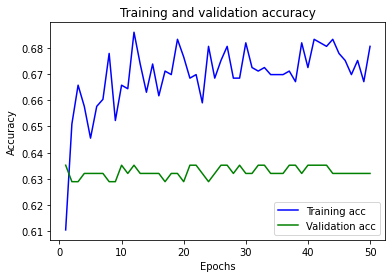

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='green')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
max(history.history['val_accuracy'])

0.6415094137191772

In [90]:
model_cat = CatBoostRegressor(iterations=2000,
                          early_stopping_rounds=40,
                          depth=6,
                          random_state=0,
                          verbose=0,
                          use_best_model = True
                          )
model_cat.fit(X_train,y_train,
          eval_set=(X_test, y_test))

In [91]:
mean_squared_error(model_cat.predict(X_test), y_test, squared = False)

2.0428966221743723

In [93]:
abs(y_test).mean()

1.5683827635064744

<Axes: >

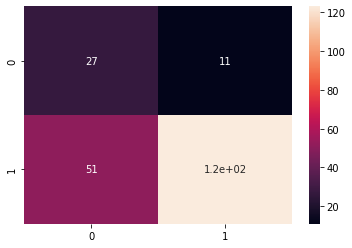

In [ ]:
sns.heatmap(confusion_matrix(model_cat.predict(X_test), y_test), annot = True)


In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, model_cat.predict_proba(X_test)[::, 1]) #model.predict(X_test)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold = {best_thresh}')
print(classification_report((model_cat.predict_proba(X_test)[::, 1] > best_thresh), y_test))

Best Threshold = 0.5057506993976978
              precision    recall  f1-score   support

       False       0.35      0.69      0.46        39
        True       0.91      0.71      0.79       173

    accuracy                           0.70       212
   macro avg       0.63      0.70      0.63       212
weighted avg       0.81      0.70      0.73       212



In [ ]:
# Initialize CatBoost Classifier
catboost = CatBoostClassifier(iterations=2000,
                          early_stopping_rounds=30,
                          depth=6,
                          random_state=0,
                          verbose=0
                          )

# Define number of folds
n_folds = 5

# Create KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize list to store accuracy scores for each fold
accuracy_scores = []

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Fit CatBoost model on training data for this fold
    catboost.fit(X_train_fold, y_train_fold)
    
    # Make predictions on validation data for this fold
    y_pred_val = catboost.predict(X_val_fold)
    
    # Calculate accuracy score for this fold and append to list
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_val))
    
    # Print accuracy score for this fold
    print(f"Fold {fold+1} Accuracy: {accuracy_scores[-1]}")
    
# Calculate and print mean accuracy score across all folds
print(f"\nMean Accuracy: {np.mean(accuracy_scores)}")


Fold 1 Accuracy: 0.6941176470588235
Fold 2 Accuracy: 0.6588235294117647
Fold 3 Accuracy: 0.7235294117647059
Fold 4 Accuracy: 0.7041420118343196
Fold 5 Accuracy: 0.6272189349112426

Mean Accuracy: 0.6815663069961714


In [ ]:
from xgboost import XGBClassifier

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
accuracy_score(y_test, predictions)

0.6415094339622641

Text(0.5, 1.0, 'Feature Importance')

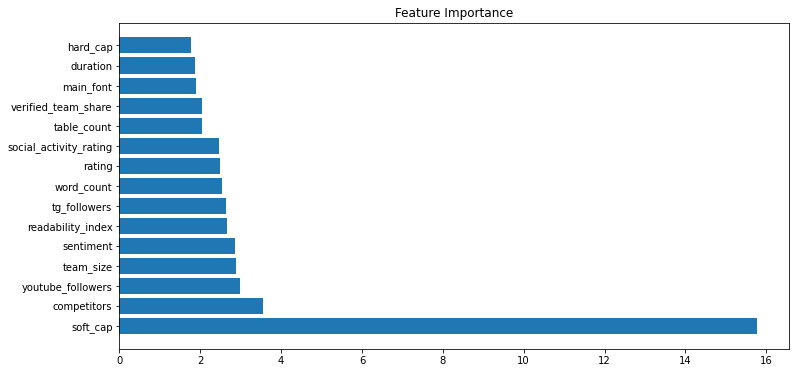

In [ ]:
### feature importance
df_imp = pd.DataFrame({'variable': X.columns, 
              'importance': model_cat.get_feature_importance()}).sort_values(by = 'importance', 
                                                                             ascending = False)
              

fig = plt.figure(figsize=(12, 6))
plt.barh(range(15), df_imp['importance'][:15], align='center')
plt.yticks(range(15), df_imp['variable'][:15])
plt.title('Feature Importance')


In [121]:
SHEET_ID = '1QgFH7NCgLRhT3meCitL2JiLwcH9uzUYOCxRxuDFm_kc'
SHEET_NAME = 'Sheet1'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
names = pd.read_csv(url).iloc[:, :5]

In [122]:
names

,Id,Column name,Description,Source,Predictor_group
0,1,name,Name of the ICO project,ICO data providers,NaN
1,2,page_count,Total number of pages in whitepaper,Whitepaper,whitepaper
2,3,word_count,Total number of words in whitepaper,NaN,whitepaper
3,4,sentence_count,Total number of sentences in whitepaper,NaN,whitepaper
4,5,average_sentence_length,Average length of sentence in words,NaN,whitepaper
...,...,...,...,...,...
64,65,main_font,ID of the main font type used in whitepaper,NaN,whitepaper
65,66,table_count,Number of tables in whitepaper,NaN,whitepaper
66,67,sentiment,Aggregated sentiment score of ICO project,Twitter,social_activities
67,68,success_binary,"Binary, whether project managed to collect sof...",Raised and soft cap,NaN


In [ ]:
df_imp = df_imp.merge(names, left_on s= 'variable', right_on = 'Column name')[['variable', 'importance', 'Predictor_group']]

In [ ]:
df_imp.groupby('Predictor_group')['importance'].agg(['mean', 'count']).sort_values(ascending = False, by = 'mean')

,mean,count
Predictor_group,,
crypto_market,2.577692,2
metadata,1.742267,21
social_activities,1.724042,8
whitepaper,1.389460,22
macro_indicators,1.068965,13


In [ ]:
grouped = df_imp.groupby("Predictor_group").apply(lambda x: x.nlargest(7, "importance"))
grouped.reset_index(drop=True, inplace = True)
grouped.groupby('Predictor_group')['importance'].agg(['mean', 'count']).sort_values(ascending = False, by = 'mean')


,mean,count
Predictor_group,,
metadata,4.189837,7
crypto_market,2.577692,2
whitepaper,1.992511,7
social_activities,1.910928,7
macro_indicators,1.339867,7


In [96]:
import shap

In [98]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(X)


In [101]:
len(shap_values)

1060

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


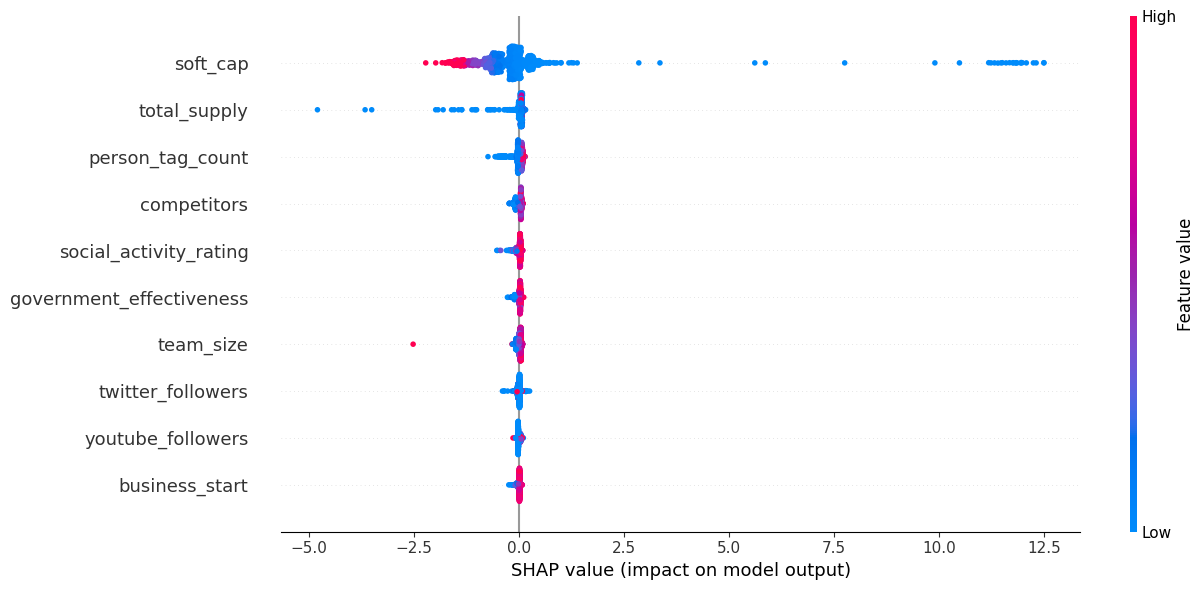

In [125]:
shap.summary_plot(shap_values, X, max_display = 10, plot_type = 'dot',  plot_size=(13, 6))


In [113]:
shap_values

array([[ 4.14320577e-02,  1.17873536e-02,  1.34270875e-02, ...,
         2.32943246e-02,  2.13829585e-02,  2.00207681e-02],
       [ 1.45383880e-02,  1.05616401e-02,  1.98625562e-02, ...,
        -2.01074712e-04, -3.40339990e-02,  2.21158793e-02],
       [ 3.09083361e-02,  5.31180175e-03,  1.26429808e-02, ...,
        -3.62377294e-03, -3.41357379e-03, -3.29158287e-02],
       ...,
       [-4.17235483e-03, -2.76048385e-03, -2.00197412e-02, ...,
         1.10926060e-04,  1.38215670e-02,  1.09438478e-02],
       [ 8.85552707e-04, -1.75270713e-02, -2.72279844e-02, ...,
         2.78299306e-03,  1.45661252e-02,  5.68953315e-05],
       [ 5.45390575e-04,  1.05755181e-03,  1.22928603e-02, ...,
         4.28324985e-03,  1.41427299e-02, -4.53300864e-02]])

In [124]:
groupes = pd.DataFrame(shap_values, columns = X.columns, index = df.index).T
groupes.mean(axis = 1).sort_values()

soft_cap                 -0.063690
person_tag_count         -0.004830
competitors              -0.003582
social_activity_rating   -0.002076
real_estate_topic        -0.001491
                            ...   
travelling_topic          0.002003
duration                  0.002028
team_size                 0.003354
page_count                0.003450
total_supply              0.004697
Length: 66, dtype: float64

In [ ]:
df_imp.merge(names, left_on s= 'variable', right_on = 'Column name')